In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import norm, invgamma, beta, bernoulli
%matplotlib notebook

In [2]:
import sys
sys.path.append("C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing")

%load_ext autoreload
%autoreload 2

In [3]:
from src.simulations import SimpleSimulation
from src.simulation_melange_gaussien import GMixSimulation
from src.simulation_uniforme import UniformSimulation
from src.simple_bandit import SimpleBandit
from src.binomial_bandit import BinomialBandit
from src.context_generator import ContextGenerator
from src.simulation_with_context import ContextualDemandSimulation
from src.evaluate_model import EvaluateBandit
from src.evaluate_with_context import EvaluateBanditContext
from src.simple_bandit_greedy import GreedyBandit
from src.simple_bandit_ucb import UCBBandit


In [4]:
simulation = SimpleSimulation(mu = 60, sigma=30)
simulation.optimal_price

47.683319091796875

In [5]:
sim_u = UniformSimulation(35,60)
sim_u.optimal_price

35.0000114440918

In [72]:
sim_mix=GMixSimulation(45,1,100,2,0.5)
sim_mix.optimal_price


95.14131546020508

In [69]:
beta_c=np.array([5,2,3])
mu_c=np.array([3,50,87])
sigma_c=np.array([1,9,10])
beta_d=np.array([[1,-1],[2,100,-1]])
n=np.array([2,3])
mu_e=-300
sigma_e=15
#instantiate context simulation
context_generator = ContextGenerator(mu_c,sigma_c,n)

#instantiate demand simulation
demand_simulation = ContextualDemandSimulation(beta_c, beta_d, mu_e, sigma_e)

# Instanciate bandit
size_context= len(mu_c) + sum(n) + 1

k_p = [10,25,15,20,30,50,35,40,5]
norm_mean = 0
norm_std = 1
m_0 = np.zeros(shape=(len(k_p),size_context)) + norm_mean
q_0 = np.zeros(shape=(len(k_p),size_context)) + norm_std


In [73]:
def plot_demand(simulation, min_price = 0, max_price = 150, n_points = 50, n_estimates_per_point = 40) : 
    prices = []
    revenues = []
    for price in np.linspace(min_price, max_price, n_points) : 
        revenues.extend( [int(simulation.evaluate(price)) * price for x in range(n_estimates_per_point)] )
        prices.extend([price for x in range(n_estimates_per_point)])
    
    a = np.array([prices, revenues])

    fig = plt.figure(figsize = (15,6), facecolor="w")
    ax = sns.lineplot(a[0], a[1])
    ax.legend("")

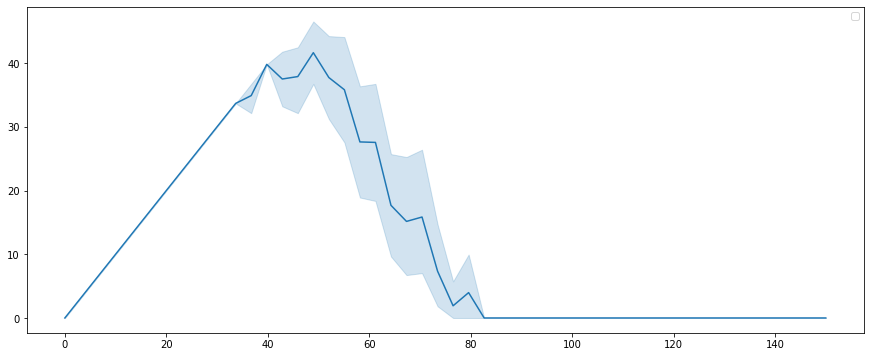

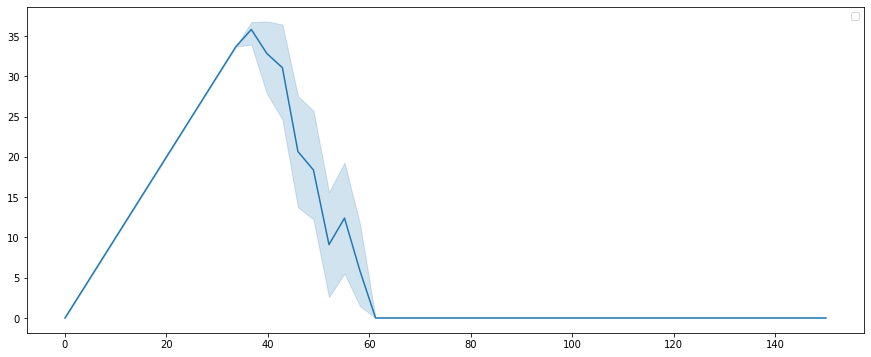

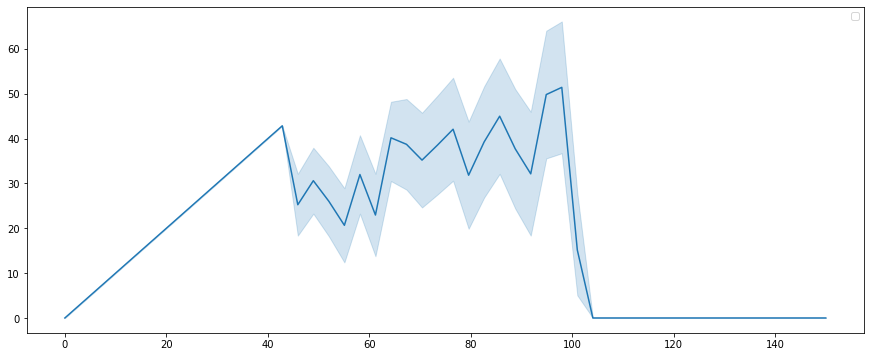

In [74]:
plot_demand(simulation)
plot_demand(sim_u)
plot_demand(sim_mix)


In [12]:
def plot_demand_context(simulation,context_generator, min_price = 0, max_price = 400, n_points = 50, n_estimates_per_point = 100) : 
    prices = []
    revenues = []
    for price in np.linspace(min_price, max_price, n_points) : 
        context_c, context_d = context_generator.simulate()
        revenues.extend( [simulation.evaluate(price,context_c, context_d) * price for x in range(n_estimates_per_point)] )
        prices.extend([price for x in range(n_estimates_per_point)])
    
    a = np.array([prices, revenues])

    fig = plt.figure(figsize = (15,6), facecolor="w")
    ax = sns.lineplot(a[0], a[1])
    ax.legend("")

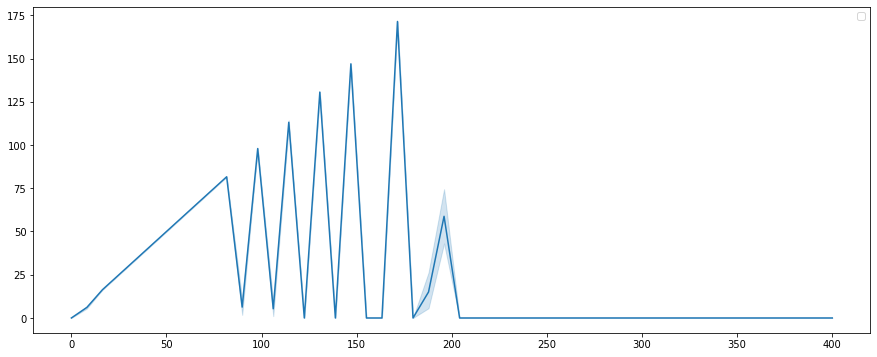

In [13]:

plot_demand_context(demand_simulation,context_generator)


In [ ]:
for _  in range(5):
    sim_context._simulate()
    print (sim_context.context[1])

### Try simple bandit algorithm on the simulations

In [75]:
size = 100

k_p = np.linspace(1,200,size)
alpha_0 = np.repeat(1,size)
beta_0 = np.repeat(1,size)

bandit = BinomialBandit(k_p, alpha_0, beta_0)

BinomialBandit model instanciated with 100 arms.


In [143]:
def test_bandit_thompson(simulation):
    hist = []
    regret = []
    reward_T = []
    parameters=np.array([np.array([alpha_0]),np.array([beta_0])])
    bandit = BinomialBandit(k_p, alpha_0, beta_0)
    evaluation=EvaluateBandit(bandit,simulation)
    # Exploration round
    for i in range(10):
        for j in range(bandit.k):
            bandit.chose_action(force_action=j)
            price = k_p[bandit.action]
            reward = int(simulation.evaluate(price)) * price
            regret.append(evaluation.get_regret(bandit.n_obs))
            bandit.update(bandit.action, reward)
            parameters = np.append(parameters,np.array([np.array([bandit.alpha_n]),np.array([bandit.beta_n])]),axis=1)

    for i in range(5000):
        bandit.chose_action(method="thompson")
        price = k_p[bandit.action]
        reward = int(simulation.evaluate(price)) * price
        regret.append(evaluation.get_regret(bandit.n_obs))
        bandit.update(bandit.action, reward)
        hist.append(bandit.action)
        parameters = np.append(parameters,np.array([np.array([bandit.alpha_n]),np.array([bandit.beta_n])]),axis=1)
    return hist,regret,parameters

In [144]:
bandit_th_sim_u=test_bandit_thompson(sim_u)
bandit__th_sim_mix=test_bandit_thompson(sim_mix)
bandit_th_sim=test_bandit_thompson(simulation)



BinomialBandit model instanciated with 100 arms.
BinomialBandit model instanciated with 100 arms.
BinomialBandit model instanciated with 100 arms.


In [145]:
plt.plot(bandit_th_sim_mix[1])
plt.plot(bandit_th_sim_u[1])
plt.plot(bandit_th_sim[1])


NameError: name 'bandit_th_sim_mix' is not defined

In [ ]:
fig = plt.figure(figsize=(10,5), facecolor="w")
ax = plt.subplot()
for _mu, _sigma in zip(m,s):
    plot_distrib_normal(_mu,_sigma, ax, x_min=-5000, x_max=5000, n_points=200)

In [108]:
def plot_distrib_beta(alpha_param, beta_param, ax, n_points = 100, label = None):
    x = np.linspace(0, 1, n_points)
    y = beta.pdf(x, alpha_param, beta_param)
    ax.plot(x,y, label=label)
    return ax

def sample_theta(bandit):
    # Sample sigma
    theta = beta.rvs(bandit.alpha_n, bandit.beta_n)
    plt.axvline(theta)
    return theta

In [109]:
n_points = 100
_beta =bandit_sim[2][1][1000][8]
_alpha =bandit_sim[2][0][1000][8]
x = np.linspace(0, 1, n_points)
y = beta.pdf(x,_alpha, _beta)

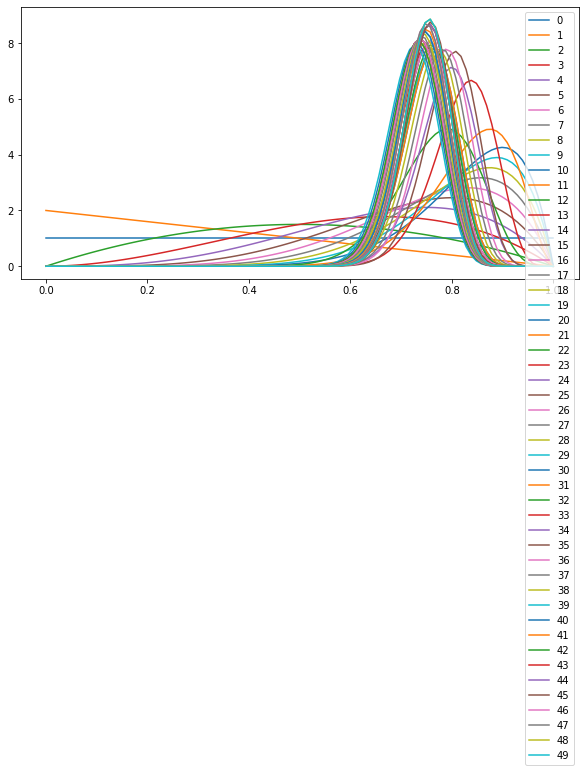

In [118]:
fig = plt.figure(figsize=(10,5), facecolor="w")
ax = plt.subplot()
for i in range(50):
    _alpha = bandit_sim[2][0][i*100][25]
    _beta = bandit_sim[2][1][i*100][25]
    plot_distrib_beta(_alpha,_beta, ax,label=i)
    i+=1
    ax.legend()

In [ ]:
#simulation somme de normale
hist_uniform,regret_uniform=test_bandit(sim_u)

occ = sorted(Counter(hist_uniform).items(), key = lambda k : k[1])
for index, nb_occ in occ : 
    print(f"Bucket {index} -- Nb occ {nb_occ} -- Price {bandit.k_p[index]}")

In [ ]:
evaluation.T
self.T*self.exp_revenue[self.best_action] - np.sum([self.n_obs[i]*self.exp_revenue[i] for i in range(len(self.k_p))])

In [ ]:
bandit.n_obs

In [ ]:
#simulation uniforme
hist_u=test_bandit(sim_u)
occ = sorted(Counter(hist_u).items(), key = lambda k : k[1])
for index, nb_occ in occ : 
    print(f"Bucket {index} -- Nb occ {nb_occ} -- Price {bandit.k_p[index]}")

In [ ]:
#simulation mélange gaussien
hist_mix=test_bandit(sim_mix)
occ = sorted(Counter(hist_mix).items(), key = lambda k : k[1])
for index, nb_occ in occ : 
    print(f"Bucket {index} -- Nb occ {nb_occ} -- Price {bandit.k_p[index]}")

In [ ]:
def test_bandit_greedy(simulation):
    hist = []
    regret = []
    reward_T = []
    c=5
    d=7
    bandit = GreedyBandit(k_p, d,c)
    evaluation=EvaluateBandit(bandit,simulation)
    # Exploration round
    for i in range(10):
        for j in range(bandit.k):
            bandit.chose_action(force_action=j)
            price = k_p[bandit.action]
            reward = int(simulation.evaluate(price)) * price
            regret.append(evaluation.get_regret(bandit.n_obs))
            bandit.update(bandit.action, reward)

    for i in range(5000):
        bandit.chose_action(method="greedy")
        price = k_p[bandit.action]
        reward = int(simulation.evaluate(price)) * price
        regret.append(evaluation.get_regret(bandit.n_obs))
        bandit.update(bandit.action, reward)
        hist.append(bandit.action)
        
    return hist,regret

In [146]:
bandit_greedy_sim_u=test_bandit_greedy(sim_u)
bandit_greedy_sim_mix=test_bandit_greedy(sim_mix)
bandit_greedy_sim=test_bandit_greedy(simulation)


BinomialBandit model for espilon-greedy instanciated with 100 arms.
BinomialBandit model for espilon-greedy instanciated with 100 arms.
BinomialBandit model for espilon-greedy instanciated with 100 arms.


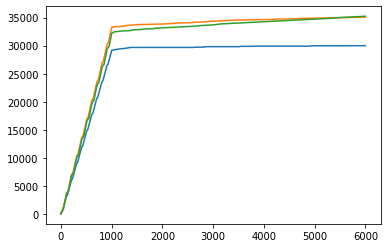

In [148]:
plt.plot(bandit_greedy_sim_u[1])
plt.plot(bandit_greedy_sim[1])
plt.plot(bandit_greedy_sim_mix[1])

In [149]:
occ = sorted(Counter(bandit_greedy_sim_mix[0]).items(), key = lambda k : k[1])
for index, nb_occ in occ : 
    print(f"Bucket {index} -- Nb occ {nb_occ} -- Price {bandit.k_p[index]}")

Bucket 2 -- Nb occ 1 -- Price 5.02020202020202
Bucket 32 -- Nb occ 1 -- Price 65.32323232323232
Bucket 0 -- Nb occ 1 -- Price 1.0
Bucket 79 -- Nb occ 1 -- Price 159.7979797979798
Bucket 3 -- Nb occ 1 -- Price 7.030303030303029
Bucket 93 -- Nb occ 1 -- Price 187.93939393939394
Bucket 33 -- Nb occ 1 -- Price 67.33333333333333
Bucket 71 -- Nb occ 1 -- Price 143.7171717171717
Bucket 22 -- Nb occ 1 -- Price 45.22222222222222
Bucket 78 -- Nb occ 1 -- Price 157.78787878787878
Bucket 77 -- Nb occ 1 -- Price 155.77777777777777
Bucket 81 -- Nb occ 1 -- Price 163.8181818181818
Bucket 35 -- Nb occ 2 -- Price 71.35353535353535
Bucket 45 -- Nb occ 3 -- Price 91.45454545454545
Bucket 39 -- Nb occ 8 -- Price 79.39393939393939
Bucket 48 -- Nb occ 15 -- Price 97.48484848484847
Bucket 42 -- Nb occ 21 -- Price 85.42424242424242
Bucket 44 -- Nb occ 23 -- Price 89.44444444444444
Bucket 46 -- Nb occ 4916 -- Price 93.46464646464646


In [156]:
def test_bandit_ucb(simulation):
    hist = []
    regret = []
    reward_T = []
    bandit = UCBBandit(k_p)
    evaluation=EvaluateBandit(bandit,simulation)
    # Exploration round
    for i in range(10):
        for j in range(bandit.k):
            bandit.chose_action(force_action=j)
            price = k_p[bandit.action]
            reward = int(simulation.evaluate(price)) * price
            regret.append(evaluation.get_regret(bandit.n_obs))
            bandit.update(bandit.action, reward)

    for i in range(5000):
        bandit.chose_action(method="UCB")
        price = k_p[bandit.action]
        reward = int(simulation.evaluate(price)) * price
        regret.append(evaluation.get_regret(bandit.n_obs))
        bandit.update(bandit.action, reward)
        hist.append(bandit.action)
        
    return hist,regret

In [157]:
bandit_ucb_sim_u=test_bandit_ucb(sim_u)
bandit_ucb_sim_mix=test_bandit_ucb(sim_mix)
bandit_ucb_sim=test_bandit_ucb(simulation)


BinomialBandit model for UCB instanciated with 100 arms.
BinomialBandit model for UCB instanciated with 100 arms.
BinomialBandit model for UCB instanciated with 100 arms.


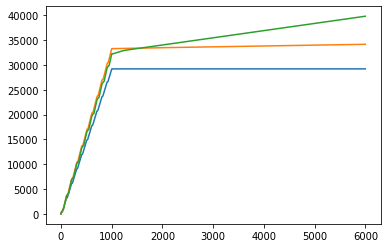

In [158]:
plt.plot(bandit_ucb_sim_u[1])
plt.plot(bandit_ucb_sim[1])
plt.plot(bandit_ucb_sim_mix[1])

In [159]:
occ = sorted(Counter(bandit_ucb_sim_mix[0]).items(), key = lambda k : k[1])
for index, nb_occ in occ : 
    print(f"Bucket {index} -- Nb occ {nb_occ} -- Price {bandit.k_p[index]}")

Bucket 41 -- Nb occ 1 -- Price 83.41414141414141
Bucket 40 -- Nb occ 4 -- Price 81.4040404040404
Bucket 21 -- Nb occ 14 -- Price 43.21212121212121
Bucket 42 -- Nb occ 94 -- Price 85.42424242424242
Bucket 45 -- Nb occ 4887 -- Price 91.45454545454545


## test du contextual bandit !

In [ ]:
k_p=[1,50,100]
size_context=4
q_0=np.array([1,1,1,1])
q_0= np.repeat(q_0[np.newaxis,:],len(k_p),axis=0)
q_0[1]
m_0=np.zeros(shape=(len(k_p),size_context))
m_0

In [ ]:
from src.context_bandit import ContextBandit
bandit=ContextBandit(k_p,size_context,m_0,q_0)

In [ ]:
j = 1

In [ ]:
int(simulation.evaluate(price)) * price

In [ ]:
sim_context.evaluate()

In [ ]:
        bandit.chose_action(force_action=j)
        price = k_p[bandit.action]
        reward = int(simulation.evaluate(price)) * price
        bandit.update(bandit.action, reward)

In [ ]:
hist = []
# Exploration round
for i in range(size * 40):
    for j in range(bandit.k):
        bandit.chose_action(force_action=j)
        price = k_p[bandit.action]
        reward = int(simulation.evaluate(price)) * price
        bandit.update(bandit.action, reward)

for i in range(1000):
    bandit.chose_action(method="thompson")
    price = k_p[bandit.action]
    reward = int(simulation.evaluate(price)) * price
    bandit.update(bandit.action, reward)
    hist.append(bandit.action)

In [ ]:
n=[3,4,5]
np.random.randint([1,1,1],n)

In [ ]:
dummies = [np.zeros(i) for i in n]
for variable in dummies : 
    random_index = np.random.randint(len(variable))
    variable[random_index] = 1
    
dummies = [y for x in dummies for y in x] # flat list

In [ ]:
from src.context_generator import ContextGenerator

In [ ]:
context_generator = ContextGenerator([1,2,3], [2,3,2], n_discrete=[2,4])

In [ ]:
context_c, context_d = context_generator.simulate()

beta_c = [1,2,1] 
beta_d = [[1,2], [6,8,3,1]]
mu_e = 2
sigma_e = 5

demand_simulation = ContextualDemandSimulation(beta_c, beta_d, mu_e, sigma_e)

In [ ]:
demand_simulation.evaluate(17, context_c, context_d)

In [ ]:
class ContextualDemandSimulation():
    """
    Demand simulation for contextual bandit v=BX +E
    with X=(X_c X_d) and X_c ~G() ;X_d ~U() and ? E~simple simul ?
    """
    def __init__(self,beta_c,beta_d,mu_e,sigma_e):
        self.beta_c= np.array(beta_c)
        self.beta_d = np.array(beta_d) #array with impact of each category
        self.mu_e= np.array(mu_e)
        self.sigma_e= np.array(sigma_e)
    
    def _get_context_impact(self, continuous_context, discrete_context):
        # Continuous impact
        cont = self.beta_c * np.array(continuous_context)
        disc = [sum(np.array(beta) * np.array(disc)) for beta,disc in zip(beta_d, discrete)]        
        return sum(cont) + sum(disc)
    
    def _simulate(self, continuous_context, discrete_context):
        cont = self._get_context_impact(continuous_context, discrete_context)
        s=-1
        while s < 0:
            s_i = np.random.normal(self.mu_e,self.sigma_e,1)
            s=s_i + cont
        return s[0]
    
    def evaluate(self,p, continuous_context, discrete_context):
        """
        Return bool : True if buy False either
        """
        sample = self._simulate(continuous_context, discrete_context)
        return int(sample >= p)

In [ ]:
obs=np.array([2,3,6,0,5,0,8])
pos=np.array([1,0,4,0])
a= np.array([1,0,4,0])

1*(obs==0)-1*(obs!=0)

In [ ]:
t=np.array(range(4))
t-